# Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

#Create Circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)


(1000, 1000)

In [ ]:
print(f"First 5 samples of X: {X[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [ ]:
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of y: [1 1 1 1 0]


In [ ]:
#Make Dataframe of circle data

import pandas as pd
circles = pd.DataFrame({'X1':X[:,0],'X2':X[:,1],'label':y })

In [ ]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


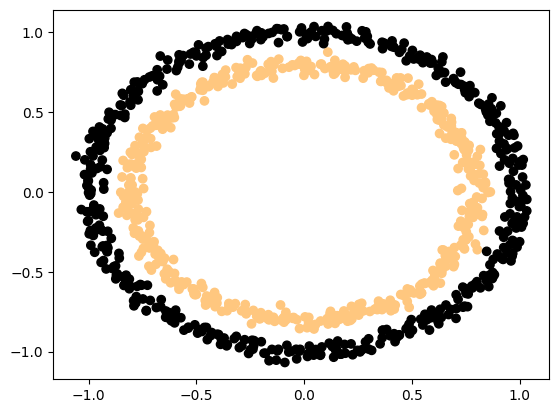

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap='copper')

## 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X_sample = X[0]

In [ ]:
X_sample.shape

(2,)

In [ ]:
X_sample

array([0.75424625, 0.23148074])

In [ ]:
import torch
torch.__version__

'2.6.0+cu124'

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)



In [ ]:
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [ ]:
#Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,
                                                   random_state=78)

len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

# 2. Model Building

In [ ]:
import torch
from torch import nn

device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2,50)
        self.l2 = nn.Linear(50,1)

        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(2,5),
        #     nn.Linear(5,1)
        # )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

#Instantiate and send to target device
cm = CircleModel()
cm = cm.to(device)

In [ ]:
cm

CircleModel(
  (l1): Linear(in_features=2, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
next(cm.parameters()).device

device(type='cpu')

In [ ]:
#Replicating same with nn.Sequential

cm2 = nn.Sequential(
    nn.Linear(2,5),
    nn.Linear(5,1)
).to(device)

cm2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
cm2.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6792, -0.1602],
                      [-0.2267, -0.1026],
                      [-0.3211,  0.3940],
                      [-0.3880, -0.6957],
                      [-0.1749,  0.1830]])),
             ('0.bias', tensor([ 0.6785,  0.6159,  0.5852,  0.0307, -0.5027])),
             ('1.weight',
              tensor([[-0.2937, -0.0017,  0.1860,  0.2364,  0.0226]])),
             ('1.bias', tensor([-0.3898]))])

In [ ]:
cm2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#Setup the loss function
loss_fn =   nn.BCEWithLogitsLoss()  #Has sigmoid activation function builtin

optimizer = torch.optim.SGD(params=cm.parameters(), lr=0.1)

#Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) *100
    return acc







#Train model
1. Forward pass
2. Calculate loss
3. optimizer zero grad
4. loss backward
5. Optimizer step (grad descent)

In [ ]:
#View the first 5 outputs of forward pass
cm.eval()

with torch.inference_mode():
    y_logits = cm(X_test.to(device))[:5]
y_logits


tensor([[-0.1022],
        [ 0.0705],
        [-0.1369],
        [-0.1043],
        [ 0.0692]])

In [ ]:
y_pred_prods = torch.sigmoid(y_logits)
y_pred_prods

tensor([[0.4745],
        [0.5176],
        [0.4658],
        [0.4740],
        [0.5173]])

In [ ]:
torch.round(y_pred_prods)

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.]])

#Training and testing loop

In [ ]:
torch.manual_seed(78)
torch.cuda.manual_seed(78)

#Set the epochs
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    cm.train()

    #Forward Pass
    y_logits = cm(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #calculate loss
    loss = loss_fn(y_logits,y_train
                   )

    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    #Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    #Optimizer step
    optimizer.step()

    #Testing
    cm.eval()
    with torch.inference_mode():
        test_logits = cm(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #Calculate test loss /acc
        test_loss = loss_fn(test_logits,y_test)

        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}. Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")






Epoch: 0 | Loss: 0.69618. Acc: 47.25% | Test Loss: 0.68945, Test Acc: 52.50%
Epoch: 10 | Loss: 0.69344. Acc: 49.62% | Test Loss: 0.69277, Test Acc: 52.00%
Epoch: 20 | Loss: 0.69292. Acc: 52.75% | Test Loss: 0.69463, Test Acc: 47.50%
Epoch: 30 | Loss: 0.69280. Acc: 52.50% | Test Loss: 0.69558, Test Acc: 45.00%
Epoch: 40 | Loss: 0.69277. Acc: 52.88% | Test Loss: 0.69604, Test Acc: 45.00%
Epoch: 50 | Loss: 0.69277. Acc: 52.12% | Test Loss: 0.69627, Test Acc: 46.00%
Epoch: 60 | Loss: 0.69277. Acc: 52.00% | Test Loss: 0.69638, Test Acc: 46.00%
Epoch: 70 | Loss: 0.69277. Acc: 51.88% | Test Loss: 0.69643, Test Acc: 46.50%
Epoch: 80 | Loss: 0.69277. Acc: 51.75% | Test Loss: 0.69646, Test Acc: 47.00%
Epoch: 90 | Loss: 0.69277. Acc: 51.75% | Test Loss: 0.69647, Test Acc: 47.00%


# Visualizing the Classification Boundary

In [ ]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("Python file already exists")
else:
    print("Downloading...")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Downloading...


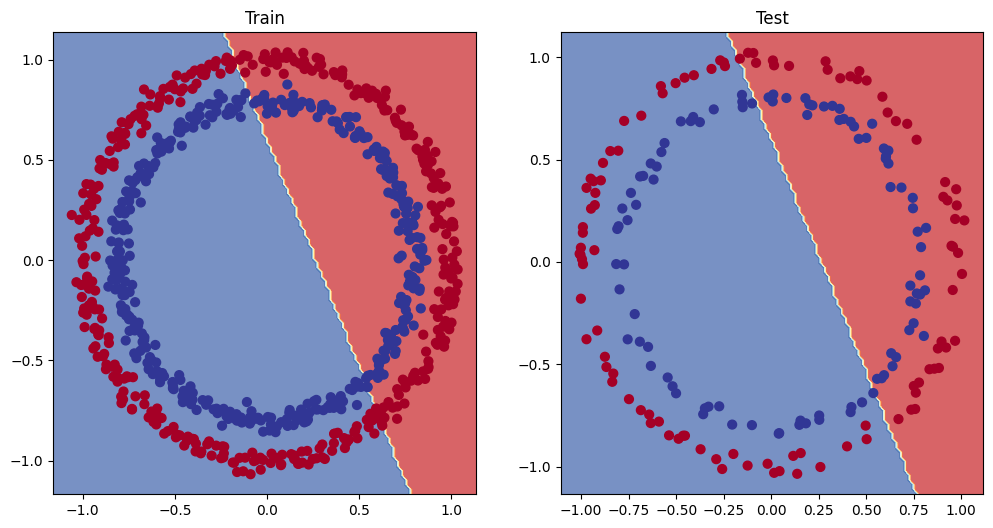

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")

plot_decision_boundary(cm, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(cm, X_test, y_test)


# Model Improvement

In [ ]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 128)
        self.l2 = nn.Linear(128,256)
        self.l3 = nn.Linear(256,128)
        self.l4 = nn.Linear(128,1)

    def forward(self,x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return x

cmv1 = CircleModelV2().to(device)
cmv1

CircleModelV2(
  (l1): Linear(in_features=2, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=1, bias=True)
)

## Non Linearity


In [ ]:
class CircleModelNonLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2,10)
        self.l2 = nn.Linear(10,10)
        self.l3 = nn.Linear(10,1)

        self.relu = nn.ReLU()

    def forward(self, x):
        z = self.l1(x)
        z = self.relu(z)
        z = self.l2(z)
        z = self.relu(z)
        z = self.l3(z)

m3 = CircleModelNonLinear().to(device)
m3

CircleModelNonLinear(
  (l1): Linear(in_features=2, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=10, bias=True)
  (l3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(m3.parameters(),lr=0.1)


# Creating a Relu Function

In [ ]:
x = torch.arange(-10,10,1, dtype=float)
x

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.], dtype=torch.float64)

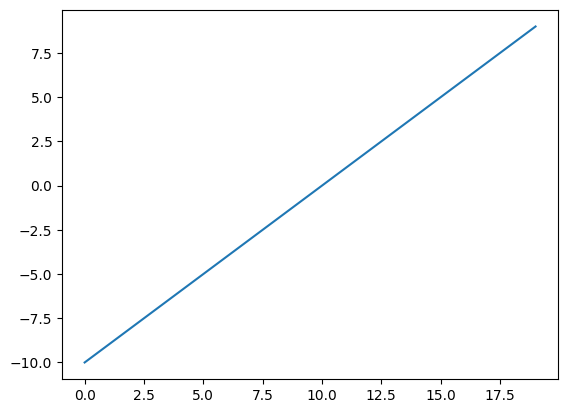

In [ ]:
plt.plot(x)

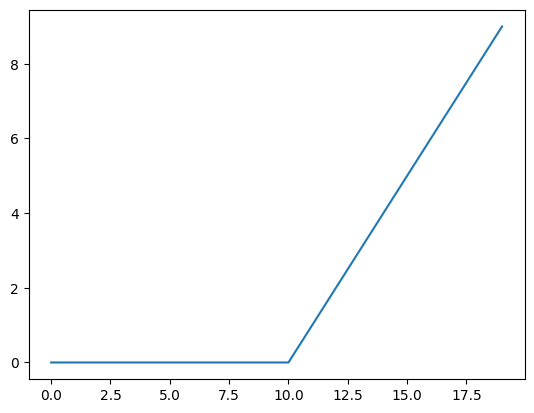

In [ ]:
plt.plot(torch.relu(x))

In [ ]:
x

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.], dtype=torch.float64)

In [ ]:
# def relu(tensor):
#     if tensor >0:
#         return tensor
#     else:
#         return 0

# relu(x)

def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0),x)
relu(x)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.], dtype=torch.float64)

In [ ]:
# Sigmoid Activation function
# sigmoid(x) = 1/1+e^(-x)

def sigmoidsai(x):
    return 1 / (1+ torch.exp(-x))

A = torch.arange(-3,3,0.3)



In [ ]:
A

tensor([-3.0000e+00, -2.7000e+00, -2.4000e+00, -2.1000e+00, -1.8000e+00,
        -1.5000e+00, -1.2000e+00, -9.0000e-01, -6.0000e-01, -3.0000e-01,
        -2.3842e-08,  3.0000e-01,  6.0000e-01,  9.0000e-01,  1.2000e+00,
         1.5000e+00,  1.8000e+00,  2.1000e+00,  2.4000e+00,  2.7000e+00])

([<matplotlib.lines.Line2D at 0x7b9fa3aaf050>],
 [<matplotlib.lines.Line2D at 0x7b9fa28ffdd0>])

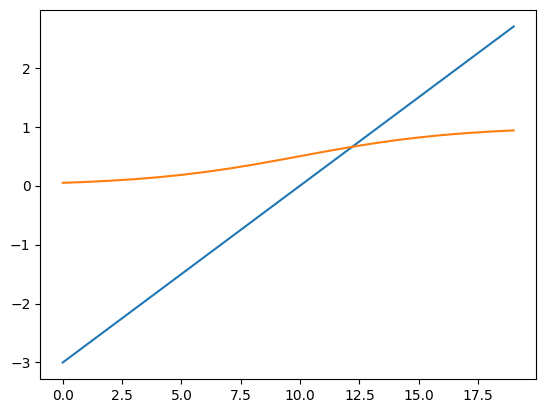

In [ ]:
plt.plot(A), plt.plot(torch.sigmoid(A))

([<matplotlib.lines.Line2D at 0x7b9fa28805d0>],
 [<matplotlib.lines.Line2D at 0x7b9fa28a00d0>])

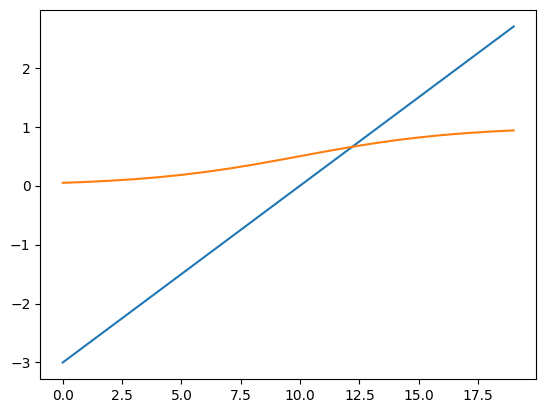

In [ ]:
plt.plot(A), plt.plot(sigmoidsai(A))

In [ ]:
torch.sigmoid(A)

tensor([0.0474, 0.0630, 0.0832, 0.1091, 0.1419, 0.1824, 0.2315, 0.2891, 0.3543,
        0.4256, 0.5000, 0.5744, 0.6457, 0.7109, 0.7685, 0.8176, 0.8581, 0.8909,
        0.9168, 0.9370])

# Multi Class Dataset

In [ ]:
#Import libraries
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED= 42

# Create multiclass data
X_blob, y_blob = make_blobs(1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# Turn data to tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)


Xbtrain, Xbtest, ybtrain, ybtest = train_test_split(X_blob, y_blob, test_size=0.2)

# Multi class Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [ ]:
class BlobModel(nn.Module):
    def __init__(self, in_features, out_features,hidden_units=8):
        super().__init__()
        self.l1 = nn.Linear(in_features,hidden_units)
        self.l2 = nn.Linear(hidden_units,hidden_units)
        self.l3 = nn.Linear(hidden_units, out_features)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.l3(self.relu(self.l2(self.relu(self.l1(x)))))


In [ ]:
class BlockModelV2(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=8):
        super().__init__()
        self.sstack = nn.Sequential(
            nn.Linear(in_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, out_features)
        )

    def forward(self,x):
        return self.sstack(x)


In [ ]:
bm = BlockModelV2(2,4,8).to(device)

In [ ]:
torch.eq(torch.tensor([1,2,3,4]),torch.tensor([3,2,3,4])).sum()

tensor(3)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bm.parameters())
epochs = 1000

import torch
# from torcheval.metrics import MulticlassAccuracy

def acc_calc_fn(y_logits, y_true):
    acc_calc = nn.Softmax(dim=1)
    y_preds = acc_calc(y_logits)
    y_p = torch.argmax(y_preds, dim=1)

    up = torch.eq(y_p,y_true).sum()
    return up/len(y_true)







In [ ]:
for epoch in range(epochs):
    #Training mode
    bm.train()

    #Forward Pass
    y_preds = bm(Xbtrain)
    loss = loss_fn(y_preds, ybtrain)

    acc_train = acc_calc_fn(y_preds, ybtrain)

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss backward
    loss.backward()

    #Optimizer step
    optimizer.step()

    bm.eval()

    with torch.inference_mode():
        y_preds_test = bm(Xbtest)
        test_loss = loss_fn(y_preds_test, ybtest)
        acc_test = acc_calc_fn(y_preds_test, ybtest)

    if epoch % 10 ==0:
        print(f"Epoch {epoch}, Train ACC {acc_train:.2f}, Train Loss {loss:.2f}, Test Acc {acc_test:.2f}, Test Loss{test_loss:.2f}")



In [ ]:
# A few classification metrics